# Construcao da rede neural - Analise do CQI
A rede neural proposta vai analisar o report de CQI de um UE a uma BSS de LTE-A em 2500 frames. As configuracoes de simulacao sao:

- NFrames = 2500;

- SNRdB = 6.0.


Configuracao UE:

- RMC R.3;

- CFI = 1;

- HARQ desligado.

Modelo de propagacao:

- Seed = 10;
- 4 Antenas receptoras;
- Modelo de delay EPA;
- Doppler Freq = 5Hz;
- Alta correlacao (MIMO);
- Modelo de Rayleigh GMEDS;
- 16 osciladores no modelo.


Delay do CQI:

- CQI Delay = 8 subframes.

## Importando bibliotecas

In [1]:
pip install tensorflow==1.15

  Created wheel for termcolor: filename=termcolor-1.1.0-py3-none-any.whl size=4835 sha256=d437fc16b50303c9b2893658a575d7a774eaf35360e75d7dc747db08541ca56b
  Stored in directory: c:\users\patri\appdata\local\pip\cache\wheels\3f\e3\ec\8a8336ff196023622fbcb36de0c5a5c218cbb24111d1d4c7f2
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7547 sha256=e946cdefa2c2498db36e16f63b4e3d2b5e241f248ac643ca810b8fc6604d8f24
  Stored in directory: c:\users\patri\appdata\local\pip\cache\wheels\21\7f\02\420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
  Created wheel for absl-py: filename=absl_py-0.9.0-py3-none-any.whl size=121935 sha256=f6442b5bdebd82488ce079be676e1340846f88ada9e5d1bcd5a09ae9ff5d7fdc
  Stored in directory: c:\users\patri\appdata\local\pip\cache\wheels\cc\af\1a\498a24d0730ef484019e007bb9e8cef3ac00311a672c049a3e
Successfully built termcolor gast absl-py
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf

## Análise dos dados gerados

In [3]:
#Seed 10
cqi = pd.read_csv("Seed_10/Adaptação/CQIReport.csv", index_col = "Indice")
sinr = pd.read_csv("Seed_10/Adaptação/SINRReport.csv", index_col = "Indice")

##Seed 9
#cqi = pd.read_csv("Seed_9/Adaptação/CQIReport.csv", index_col = "Indice")
#sinr = pd.read_csv("Seed_9/Adaptação/SINRReport.csv", index_col = "Indice")
#
##Seed 8
#cqi = pd.read_csv("Seed_8/Adaptação/CQIReport.csv", index_col = "Indice")
#sinr = pd.read_csv("Seed_8/Adaptação/SINRReport.csv", index_col = "Indice")
#
##Seed 7
#cqi = pd.read_csv("Seed_7/Adaptação/CQIReport.csv", index_col = "Indice")
#sinr = pd.read_csv("Seed_7/Adaptação/SINRReport.csv", index_col = "Indice")

In [4]:
cqi.head()

,CQI
Indice,
1,13
2,13
3,13
4,13
5,13


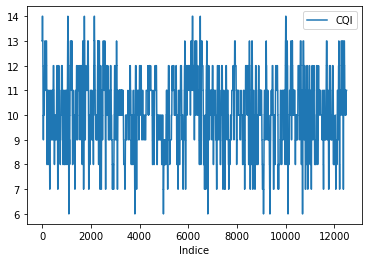

In [5]:
cqi.plot()

In [6]:
sinr.head()

,SINR
Indice,
1,19357.0
2,19879.0
3,20033.0
4,20214.0
5,20.2


Conforme podemos ver, o Matlab teve problema para importar o SINR. Como eram valores com ate 3 casas decimais apos a virgula, o Matlab salvou estes valores sem discernir as casas decimais, por isso e necessario um codigo de adaptacao dos dados antes de qualquer coisa.

In [7]:
for i in range (1, len(sinr)+1):
  if sinr['SINR'][i] > 1000:
    sinr['SINR'][i] = sinr['SINR'][i] * 0.001

In [8]:
sinr.head()

,SINR
Indice,
1,19.357
2,19.879
3,20.033
4,20.214
5,20.200


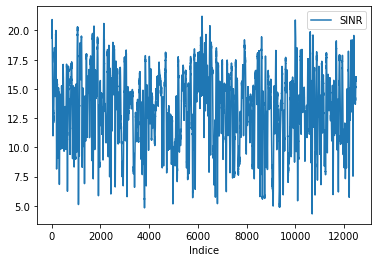

In [9]:
sinr.plot()

Plotando as duas imagens lado a lado, podemos ter uma nocao da dependencia do SINR que o CQI tem.

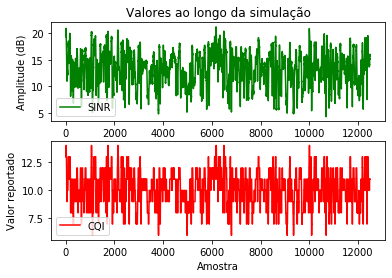

In [10]:
x = range(0, 12500)
plt.subplot(2, 1, 1)
plt.title("Valores ao longo da simulação")
plt.plot(x, sinr['SINR'], 'g', label='SINR')
plt.ylabel('Amplitude (dB)')
plt.legend()

plt.subplot(2,1,2)
plt.plot(x, cqi['CQI'], 'r', label='CQI')
plt.xlabel('Amostra')
plt.ylabel('Valor reportado')
plt.legend()
plt.savefig('Resultadosfull.png')

Analisando somente uma parcela dos resultados, podemos ter a mesma confirmacao.

No handles with labels found to put in legend.
No handles with labels found to put in legend.


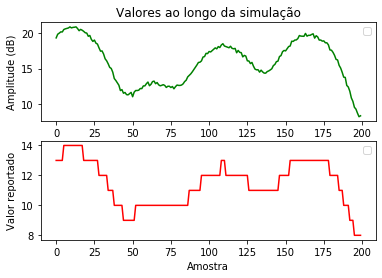

In [11]:
x = range(0, 200)
plt.subplot(2, 1, 1)
plt.title("Valores ao longo da simulação")
plt.plot(x, sinr['SINR'][0:200], 'g')
plt.ylabel('Amplitude (dB)')
plt.legend()


plt.subplot(2,1,2)
plt.plot(x, cqi['CQI'][0:200], 'r')
plt.xlabel('Amostra')
plt.ylabel('Valor reportado')
plt.legend()
plt.savefig('Resultados.png')

## Transformacao do indice em uma serie temporal
Aqui, uma "artimanha" foi usada. Para transformar a serie de reports do CQI em uma serie temporal, a coluna de Indice foi transformada em "datetime". Inicialmente, isto implicara em um erro, ja que a coluna ficara inteiramente confusa, mas mais adiante isto sera crucial para o funcionamento da RNN.

In [12]:
cqi.index = pd.to_datetime(cqi.index)

In [13]:
cqi.head()

,CQI
Indice,
1970-01-01 00:00:00.000000001,13
1970-01-01 00:00:00.000000002,13
1970-01-01 00:00:00.000000003,13
1970-01-01 00:00:00.000000004,13
1970-01-01 00:00:00.000000005,13


## Train Test Split
Divisao dos CQI reportados entre base de treinamento e base de teste.

In [14]:
cqi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12500 entries, 1970-01-01 00:00:00.000000001 to 1970-01-01 00:00:00.000012500
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   CQI     12500 non-null  int64
dtypes: int64(1)
memory usage: 195.3 KB


In [15]:
train_set = cqi.head(12400)
test_set = cqi.tail(100)

## Adaptação dos dados

Os dados serao adaptados pelo algoritmo MinMaxScaler para que possam ser processados.

In [16]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

train_scaled = scaler.fit_transform(train_set)
test_scaled = scaler.transform(test_set)

## Função de batch

Para diminuir a complexidade do script, uma funcao para alimentar a rede em batches (lotes) sera usada.

In [17]:
def next_batch(training_data,batch_size,steps):
    
    rand_start = np.random.randint(0,len(training_data)-steps) 

    y_batch = np.array(training_data[rand_start:rand_start+steps+1]).reshape(1,steps+1)

    return y_batch[:, :-1].reshape(-1, steps, 1), y_batch[:, 1:].reshape(-1, steps, 1) 

## Construção da rede

Primeiramente vamos setar as variaveis da rede, que sao:

- Numero de entradas: quantas variaveis serao usadas como input na rede (no caso, apenas uma);
- Numero de variaveis em cada batch;
- Numero de neurons: quantidade de celulas que a rede neural tera;
- Numero de saidas: quantas saidas a rede tera (no caso, apenas uma);
- Ritmo de aprendizado: variavel que dita o tamanho do "salto" entre cada iteracao, ditando o ritmo de aprendizado. Este valor deve ser equilibrado para uma solucao convergente da rede;
- Numero de interacoes: quantas vezes os dados serao processados para a solucao;
- Tamanho do batch.

In [18]:
# Numero de entradas
num_inputs = 1
# Numero de variaveis em cada batch
num_time_steps = 100
# Numero de neurons
num_neurons = 100
# Numero de saidas
num_outputs = 1
# Ritmo de aprendizado
learning_rate = 0.001
# Numero de interacoes
num_train_iterations = 8000
# Tamanho do batch
batch_size = 1

### Criando "espacos" (placeholders) para as variaveis de entrada e saida na rede.

In [19]:
X = tf.placeholder(tf.float32, [None, num_time_steps, num_inputs])
y = tf.placeholder(tf.float32, [None, num_time_steps, num_outputs])

### Configuracao da celula da rede
Aqui a celula usada na rede e configurada. Conforme podemos ver (pela linha comentada e a sua equivalente usada no codigo) a configuracao das celulas LSTM e GRU e bastante simples de ser feita.

In [20]:
cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.BasicLSTMCell(num_units=num_neurons, activation=tf.nn.relu),
    #tf.contrib.rnn.GRUCell(num_units=num_neurons, activation=tf.nn.relu),
    output_size=num_outputs) 

outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


### Criacao da funcao de erro/perda

In [21]:
loss = tf.reduce_mean(tf.square(outputs - y)) # MSE
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train = optimizer.minimize(loss)

### Inicializando as variaveis globais

In [22]:
init = tf.global_variables_initializer()

### Criando a instancia de salvar
Para que a rede possa ser usada na predicao, ela precisa ser salva dentro da sessao de treinamento.

In [23]:
saver = tf.train.Saver()

## Inicio da sessao da rede
A sessao sera iniciada e a cada 100 interacoes o erro quadratico medio (MSE) sera plotado.

In [24]:
i=1
mse_plot = []
with tf.Session() as sess:
    sess.run(init)
    
    for iteration in range(num_train_iterations):
        
        X_batch, y_batch = next_batch(train_scaled,batch_size,num_time_steps)
        sess.run(train, feed_dict={X: X_batch, y: y_batch})
        
        if iteration % 100 == 0:
            
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
            if iteration > 4000 and mse < 0.0006:
              break;
            mse_plot.append(mse)
    
    # Salvando o modelo
    saver.save(sess, "rede")

0 	MSE: 0.17783158
100 	MSE: 0.00360249
200 	MSE: 0.0054140966
300 	MSE: 0.006146595
400 	MSE: 0.0022697344
500 	MSE: 0.0028678149
600 	MSE: 0.002218524
700 	MSE: 0.0032824238
800 	MSE: 0.0036482213
900 	MSE: 0.0026157352
1000 	MSE: 0.0009247479
1100 	MSE: 0.0018713127
1200 	MSE: 0.0020518927
1300 	MSE: 0.0025029096
1400 	MSE: 0.0023148195
1500 	MSE: 0.0023349575
1600 	MSE: 0.0030272882
1700 	MSE: 0.0019763221
1800 	MSE: 0.0016221772
1900 	MSE: 0.0021183125
2000 	MSE: 0.0015365562
2100 	MSE: 0.002318724
2200 	MSE: 0.0016436146
2300 	MSE: 0.002039319
2400 	MSE: 0.0015021005
2500 	MSE: 0.0014575581
2600 	MSE: 0.0013079782
2700 	MSE: 0.0017109964
2800 	MSE: 0.0017067898
2900 	MSE: 0.0011236385
3000 	MSE: 0.0018690076
3100 	MSE: 0.001886141
3200 	MSE: 0.001702595
3300 	MSE: 0.0014909522
3400 	MSE: 0.0023730416
3500 	MSE: 0.0012131192
3600 	MSE: 0.0016699685
3700 	MSE: 0.0013411079
3800 	MSE: 0.0020123473
3900 	MSE: 0.00054795534
4000 	MSE: 0.0014065555
4100 	MSE: 0.0014254169
4200 	MSE: 0.

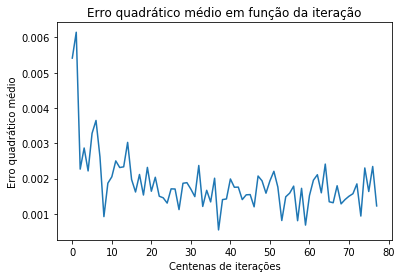

In [25]:
plt.plot(mse_plot[2:80])
plt.xlabel('Centenas de iterações')
plt.ylabel('Erro quadrático médio')
plt.title('Erro quadrático médio em função da iteração')
plt.savefig('mse.png')

## Teste de previsao
A previsao da rede funciona da seguinte forma: 

1.   A rede ja treinada e restaurada na sessao de avaliacao;
2.   O dado em t e inserido na rede ja treinada;
3.   O valor predito de t+1 é salvo.


In [26]:
with tf.Session() as sess:
    saver.restore(sess, "./rede")

    train_seed = list(train_scaled[-100:])

    for iteration in range(100):
        X_batch = np.array(train_seed[-num_time_steps:]).reshape(1, num_time_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        train_seed.append(y_pred[0, -1, 0])

INFO:tensorflow:Restoring parameters from ./rede


Os resultados sao passados para o conjunto de dados de teste em uma nova coluna "Generated"

In [27]:
results = scaler.inverse_transform(np.array(train_seed[100:]).reshape(100,1))

In [28]:
test_set['Generated'] = results

C:\Users\patri\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Conforme podemos ver a seguir, a base de teste tem 3 colunas:


*   Indice: valor que representa a passagem temporal dos frames. Conforme citado anteriormente, ele foi manipulado e apresenta-se "errado";
*   CQI: valor original, oriundo das simulações;
*   Generated: valores preditos pela rede.



In [29]:
test_set.head()

,CQI,Generated
Indice,,
1970-01-01 00:00:00.000012401,13,13.002917
1970-01-01 00:00:00.000012402,13,12.973745
1970-01-01 00:00:00.000012403,13,12.931018
1970-01-01 00:00:00.000012404,13,12.882790
1970-01-01 00:00:00.000012405,13,12.829960


## Arredondamento dos resultados e plotagem
Conforme visto anteriormente, a rede neural tenta prever o CQI do canal, porem na sua saida ha numeros com virgula. Como o valor do CQI e um numero inteiro, e necessario realizar o arredondamento dos valores da coluna "Generated"

In [30]:
test_set['Generated'] = round(test_set['Generated'])

C:\Users\patri\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [31]:
test_set

,CQI,Generated
Indice,,
1970-01-01 00:00:00.000012401,13,13.0
1970-01-01 00:00:00.000012402,13,13.0
1970-01-01 00:00:00.000012403,13,13.0
1970-01-01 00:00:00.000012404,13,13.0
1970-01-01 00:00:00.000012405,13,13.0
...,...,...
1970-01-01 00:00:00.000012496,11,9.0
1970-01-01 00:00:00.000012497,11,9.0
1970-01-01 00:00:00.000012498,11,9.0


Para realizar a correta plotagem, a correcao da base temporal sera feita. Como os reports do CQI nao tem base temporal, mas sim ordem, usaremos a variavel "x" gerada a seguir para realizar a plotagem dos resultados

In [32]:
x = range(1, len(test_set)+1)

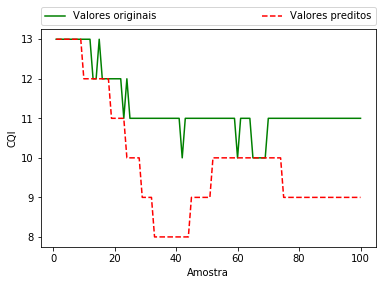

In [33]:
plt.plot(x, test_set['CQI'], 'g', label = "Valores originais")
plt.plot(x, test_set['Generated'], 'r--', label = "Valores preditos")
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.ylabel('CQI')
plt.xlabel('Amostra')
plt.savefig('Resultadossimulacao.png')

# Avaliacao dos resultados

In [34]:
total = 0
acertos = 0
i = 0

adr = 0

In [35]:
for i in range (0, num_time_steps):
  if test_set['CQI'][i] == test_set['Generated'][i]:
    acertos=acertos+1
  total=total+1
  
for i in range (0, num_time_steps):
    adr = adr + abs((test_set['Generated'][i] - test_set['CQI'][i])) / test_set['CQI'][i]
  
adr = 100*adr/num_time_steps

In [36]:
porcentagem_acertos = (acertos/total) * 100
print ("Em ", total, "subframes totais,houve um total de ", acertos, "acertos, sendo uma assertividade de ", porcentagem_acertos, "%")

print ("ADR = ", adr)

Em  100 subframes totais,houve um total de  21 acertos, sendo uma assertividade de  21.0 %
ADR =  12.644055944055935
